In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sctats

# **CPS 6:** Profit and Loss of the Black-Scholes hedging

## **1**

We want to simulate the Ornstein-Uhlenbeck process
$$
    d\sigma_t = \lambda(c-\sigma_t)\,dt + \gamma\, dW_t^{(2)}
$$
which has solution
$$
    \sigma_t = c + (\sigma_0-c)e^{-\lambda t} + \gamma\int_0^t e^{-\lambda(t-s)}\,dW_s^{(2)}.
$$

First we define a set of parameters for plotting and testing:

In [153]:
tmax = 1
n = 100
sig0 = 0.4
lbda = 2.0
c = 0.4
gamma = 0.3

In [354]:
def sigma_t(sig0, c, lbda, gamma, tmax, n, N=1000):
    """Ornstein-Uhlenbeck process.
    
    Args:
        N: number of copies (default=1000)
    
    Shape:
        N * n
    """
    dt = tmax/n
    dwt = np.sqrt(dt)*np.random.randn(n, N)
    dwt[0] = 0
    times = np.linspace(0, tmax, n, endpoint=True)
    integral_ = np.cumsum(np.exp(lbda*times)*dwt, axis=0)
    integral_term = np.exp(-lbda*times)*integral_
    res = c + (sig0-c)*np.exp(-lbda*times[:,None]) + gamma*integral_term
    return np.transpose(res)

We plot a single, example trajectory of the Ornstein-Uhlenbeck process (with a modified start value $\sigma_0 = 1.0$ to check the dynamics).

Text(0.5, 1.0, 'Volatility process $\\sigma_t$')

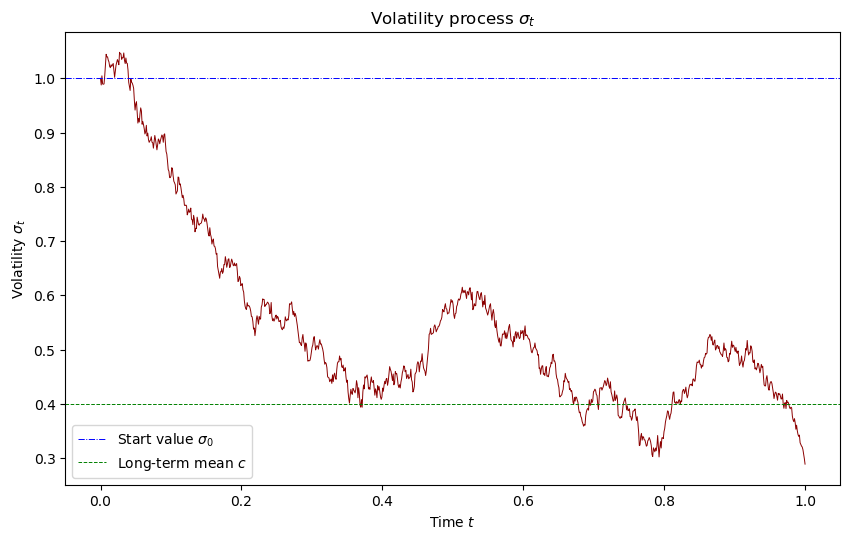

In [379]:
n = 1000
sig0 = 1.0 # different from c to check the dynamics
times = np.linspace(0, tmax, n, endpoint=True)
sig_trajectory = sigma_t(sig0, c, lbda, gamma, tmax, n, N=1)
plt.figure(figsize=(10,6), dpi=100)
plt.plot(times, sig_trajectory[0], linewidth=.7, c='darkred')
plt.xlabel('Time $t$')
plt.ylabel('Volatility $\sigma_t$')
plt.axhline(sig0, times.min(), times.max(), c='blue', linewidth=.7, linestyle='-.', label="Start value $\sigma_0$")
plt.axhline(c, times.min(), times.max(), c='green', linewidth=.7, linestyle='--', label="Long-term mean $c$")
plt.legend()
plt.title('Volatility process $\sigma_t$')

## **2**

In [386]:
def asset_price(S0, sig0, lbda, c, gamma, tmax, n, N=1000, sigma_traj=None):
    """Asset price process.
    
    Args:
        N: number of copies (default=1000)
        sigma_traj: volatility process (optional, generated by the function call)
    
    Shape:
        N * n
    """
    # Realisation of sigma on [0, tmax]
    # if not supplied
    if sigma_traj is None:
        sigma_traj = sigma_t(sig0, c, lbda, gamma, tmax, n, N).transpose()
    dt = tmax/n
    times = np.linspace(0, tmax, n, endpoint=True)
    # Sample trajectories of second brownian process
    dwt = np.sqrt(dt)*np.random.randn(n, N)
    # Volatility term: integral w.r.t. time (computed at discrete times < t)
    vol_integral = np.cumsum(np.power(sigma_traj, 2)*dt, axis=0)
    # Drift term: stochastic integral w.r.t. second brownian process
    drift_integral = np.cumsum(sigma_traj*dwt, axis=0)
    return S0*np.exp(-0.5*vol_integral + drift_integral).transpose()

In [380]:
S0 = 100

tmax = 1
n = 100
sig0 = 0.4
lbda = 2.0
c = 0.4
gamma = 0.3

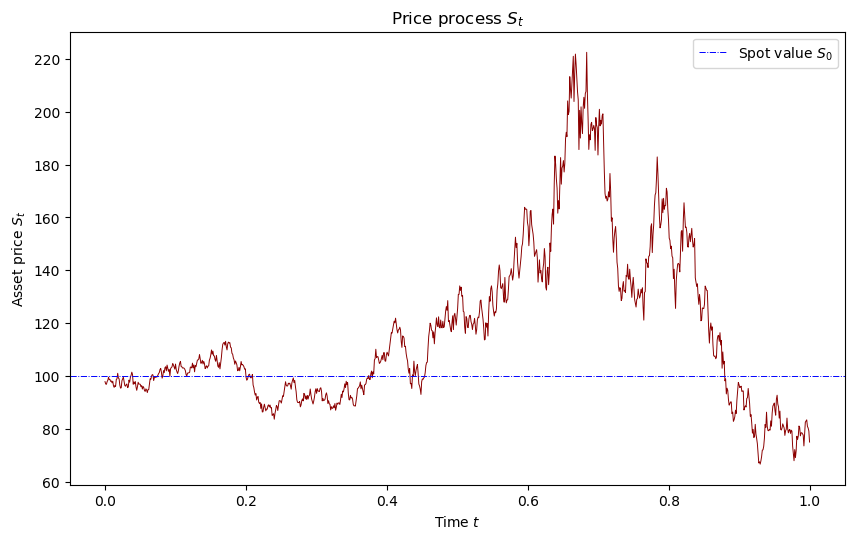

In [385]:
n = 1000
times = np.linspace(0, tmax, n, endpoint=True)
asset_trajectory = asset_price(S0, sig0, c, lbda, gamma, tmax, n, N=1)
plt.figure(figsize=(10,6), dpi=100)
plt.plot(times, asset_trajectory[0], linewidth=.7, c='darkred') # plot the first such trajectory
plt.xlabel('Time $t$')
plt.ylabel('Asset price $S_t$')
plt.title('Price process $S_t$')
plt.axhline(S0, times.min(), times.max(), c='blue', linewidth=.7, linestyle='-.', label="Spot value $S_0$")
plt.legend()

## **3**

In [ ]:
def prof_and_loss(n):
    sigma_traj = sigma_t(sig0, c, lbda, gamma, tmax, n, N)
    asset_traj = asset_price(S0, sig0, lbda, c, gamma, tmax, n, sigma_traj=sigma_traj)
    